In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Prepping data

In [3]:
kwargs = dict(consolidated=True, use_cftime=True, engine="zarr")
    
print("Load Data")
ocean_path = "gs://cmip6/GFDL_CM2_6/control/surface"
ds_ocean = xr.open_dataset(fs.get_mapper(ocean_path), chunks={"time": 3}, **kwargs)

Load Data


In [4]:
ocean_boundary_path = "gs://cmip6/GFDL_CM2_6/control/ocean_boundary"
ds_ocean_boundary = xr.open_dataset(fs.get_mapper(ocean_boundary_path), chunks={"time": 3}, **kwargs)

In [5]:
grid_path = "gs://cmip6/GFDL_CM2_6/grid"
ds_ocean_grid = xr.open_dataset(fs.get_mapper(grid_path), chunks={}, **kwargs)

In [6]:
# combine all dataset on the ocean grid together
ds_ocean = xr.merge([ds_ocean_grid, ds_ocean, ds_ocean_boundary], compat='override')
ds_ocean

<xarray.Dataset> Size: 12TB
Dimensions:                    (yt_ocean: 2700, xt_ocean: 3600, yu_ocean: 2700,
                                xu_ocean: 3600, st_edges_ocean: 51,
                                st_ocean: 50, sw_edges_ocean: 51, sw_ocean: 50,
                                nv: 2, st_ocean_sub01: 1, time: 7400)
Coordinates: (12/30)
    area_t                     (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    area_u                     (yu_ocean, xu_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt                        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxu                        (yu_ocean, xu_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt                        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyu                        (yu_ocean, xu_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ...                         ...
  * xu_ocean                   (xu_ocean) float64 29kB -279.9 -279.8 ... 80.0
  * yt_ocean                   (yt_ocean) float64 22kB -81.11 -81.07 ... 89.98
  * yu_ocean                   (yu_ocean) float64 22kB -81.09 -81.05 ... 90.0
  * nv                         (nv) float64 16B 1.0 2.0
  * st_ocean_sub01             (st_ocean_sub01) float64 8B 5.034
  * time                       (time) object 59kB 0181-01-01 12:00:00 ... 020...
Data variables: (12/41)
    biomass_p                  (time, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    chl                        (time, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    dic                        (time, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    htotal                     (time, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    irr_mix                    (time, st_ocean_sub01, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(3, 1, 2700, 3600), meta=np.ndarray>
    kw                         (time, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    ...                         ...
    sfc_hflux_pme              (time, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(106, 2700, 3600), meta=np.ndarray>
    swflx                      (time, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(106, 2700, 3600), meta=np.ndarray>
    tau_x                      (time, yu_ocean, xu_ocean) float32 288GB dask.array<chunksize=(106, 2700, 3600), meta=np.ndarray>
    tau_y                      (time, yu_ocean, xu_ocean) float32 288GB dask.array<chunksize=(106, 2700, 3600), meta=np.ndarray>
    wind_power_u               (time, yu_ocean, xu_ocean) float32 288GB dask.array<chunksize=(106, 2700, 3600), meta=np.ndarray>
    wind_power_v               (time, yu_ocean, xu_ocean) float32 288GB dask.array<chunksize=(106, 2700, 3600), meta=np.ndarray>
Attributes:
    NCO:      4.0.3

In [7]:
print("Interpolating ocean velocities")
# interpolate ocean velocities onto the tracer points using xgcm
from xgcm import Grid

# add xgcm comodo attrs
ds_ocean["xu_ocean"].attrs["axis"] = "X"
ds_ocean["xt_ocean"].attrs["axis"] = "X"
ds_ocean["xu_ocean"].attrs["c_grid_axis_shift"] = 0.5
ds_ocean["xt_ocean"].attrs["c_grid_axis_shift"] = 0.0
ds_ocean["yu_ocean"].attrs["axis"] = "Y"
ds_ocean["yt_ocean"].attrs["axis"] = "Y"
ds_ocean["yu_ocean"].attrs["c_grid_axis_shift"] = 0.5
ds_ocean["yt_ocean"].attrs["c_grid_axis_shift"] = 0.0
grid = Grid(ds_ocean)

Interpolating ocean velocities


In [8]:
# fill missing values with 0, then interpolate.
tracer_ref = ds_ocean["surface_temp"]
sst_wet_mask = ~np.isnan(tracer_ref)

ds_ocean["u_ocean"] = grid.interp_like(
    ds_ocean["usurf"].fillna(0), tracer_ref
).where(sst_wet_mask)
ds_ocean["v_ocean"] = grid.interp_like(
    ds_ocean["vsurf"].fillna(0), tracer_ref
).where(sst_wet_mask)

In [9]:
# xarray says not to do this
# ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', chunks={'time':1}, **kwargs) # noqa: E501
atmos_path = "gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr"
ds_atmos = xr.open_dataset(fs.get_mapper(atmos_path), chunks={"time": 120}, **kwargs).chunk(
    {"time": 3}
)

In [10]:
# rename the atmos data coordinates only to CESM conventions
ds_atmos = ds_atmos.rename({'grid_xt':'lon', 'grid_yt':'lat'})

In [11]:
print("Modify units")
ds_ocean["surface_temp"] = ds_ocean["surface_temp"] + 273.15
ds_atmos["slp"] = ds_atmos["slp"] * 100  # TODO: Double check this
ds_atmos

Modify units


<xarray.Dataset> Size: 1TB
Dimensions:       (time: 29586, lat: 360, lon: 576, bnds: 2)
Coordinates:
  * lon           (lon) float64 5kB 0.3125 0.9375 1.562 ... 358.4 359.1 359.7
  * lat           (lat) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time          (time) object 237kB 0120-01-01 12:00:00 ... 0200-12-31 12:0...
Dimensions without coordinates: bnds
Data variables: (12/47)
    WVP           (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    average_DT    (time) timedelta64[ns] 237kB dask.array<chunksize=(3,), meta=np.ndarray>
    average_T1    (time) object 237kB dask.array<chunksize=(3,), meta=np.ndarray>
    average_T2    (time) object 237kB dask.array<chunksize=(3,), meta=np.ndarray>
    evap          (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    grid_xt_bnds  (lon, bnds) float64 9kB dask.array<chunksize=(576, 2), meta=np.ndarray>
    ...            ...
    v500          (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    v700          (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    v850          (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    v_ref         (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    wind          (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    wind_max      (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
Attributes:
    code_version:  $Name: fre-nctools-bronx-10 $
    filename:      01200101.atmos_daily.tile1.nc
    grid_tile:     N/A
    grid_type:     regular
    history:       fregrid --input_mosaic /ptmp/rds/WGA/MOSAIC/C180_mosaic.nc...
    title:         CM2.6_miniBling

# Coarsening -- some necessary functions

In [12]:
from typing import Mapping, Any

In [13]:
def weighted_coarsen(ds:xr.Dataset, dim: Mapping[Any, int],  weight_coord:str, timedim='time', **kwargs) -> xr.Dataset:
    
    # Check that the weights have no missing values
    weights = ds[weight_coord]
    if np.isnan(weights).sum()>0:
        raise ValueError(f'Found missing values in weights coordinate ({weight_coord}). Please fill with zeros before.')
        
    # Make sure that the weights are matching the missing values in the input data 
    # (otherwise creation of aggregated area will be ambigous and depend on each variable)
    # the important thing to check is if a) all variables have the same mask and
    variable_missing = np.isnan(ds.to_array())
    
    if timedim in ds.dims:
        variable_missing = variable_missing.isel({timedim:0})
    
    variable_mask = variable_missing.any('variable').load() # loading because we need it multiple times
    variable_test = variable_missing.all('variable')
    if not variable_mask.equals(variable_test):
        raise ValueError('Found variables with non-matching missing values. ',
                         'Make sure that the missing values in **all** variables are in the same position.')
    
    # and b) if the weights have nonzero values that do not match the variables (this would lead to additional area being counted below) 
    weights_test = weights<=0
    
    a = variable_mask.squeeze(drop=True)
    b = weights_test.squeeze(drop=True)
    if not np.allclose(a, b.transpose(*a.dims)): # need to transpose this, which too me still seems un xarray-like (I discussed this in an issue once, but whatever).
        raise ValueError(
            'Missing values in variables are not matching locations of <=0 values in weights array. ',
            'Please change your weights to only have missing values or zeros where variables have missing values.'
        )
    
    # start the actual calculation
    ds_coarse = ds.coarsen(**dim, **kwargs)
    # construct internal/external dims
    construct_kwargs = {di:(di+'_external', di+'_internal') for di in dim}
    ds_construct = ds_coarse.construct(**construct_kwargs)
    
    # apply weighted mean over internal dimensions
    weights_coarse = ds_construct[weight_coord]
    aggregate_dims = [di+'_internal' for di in dim]
    ds_out = ds_construct.weighted(weights_coarse).mean(aggregate_dims)
    
    # add new area that corresponds to the area that was used for each coarse cell
    ds_out = ds_out.assign_coords(**{weight_coord:weights_coarse.sum(aggregate_dims)})
    
    # add other coordinates back
    coords_to_treat = [co for co in ds.coords if co != weight_coord and co not in ds_out.coords]
    treated_coords = {co:ds[co].coarsen({k:v for k,v in dim.items() if k in ds[co].dims}).mean() for co in coords_to_treat}
    ds_out = ds_out.assign_coords(**treated_coords)
    
    # rename to original names and return
    return ds_out.rename({di+'_external': di for di in dim})

In [14]:
def load_and_combine_cm26(
    filesystem: gcsfs.GCSFileSystem, inline_array=False
) -> xr.Dataset:
    """Loads, combines, and preprocesses CM2.6 data
    Steps:
    - Interpolate ocean velocities on ocean tracer points (with xgcm)
    - Regrid atmospheric variables to ocean tracer grid (with xesmf)
    - Match time and merge datasets
    - Adjust units for aerobulk input
    - Calculate relative wind components
    """
    kwargs = dict(
        consolidated=True, use_cftime=True, inline_array=inline_array, engine="zarr"
    )
    print("Load Data")
    mapper = filesystem.get_mapper("gs://cmip6/GFDL_CM2_6/control/surface")
    ds_ocean = xr.open_dataset(mapper, chunks={"time": 3}, **kwargs)
    mapper = filesystem.get_mapper("gs://cmip6/GFDL_CM2_6/control/ocean_boundary")
    xr.open_dataset(mapper, chunks={"time": 3}, **kwargs)

    # xarray says not to do this
    # ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', chunks={'time':1}, **kwargs) # noqa: E501
    mapper = filesystem.get_mapper("gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr")
    ds_atmos = xr.open_dataset(mapper, chunks={"time": 120}, **kwargs).chunk(
        {"time": 3}
    )
    mapper = filesystem.get_mapper("gs://cmip6/GFDL_CM2_6/grid")
    ds_oc_grid = xr.open_dataset(mapper, chunks={}, **kwargs)
    # ds_oc_grid  = cat["GFDL_CM2_6_grid"].to_dask()

    print("Align in time")
    # cut to same time
    all_dims = set(list(ds_ocean.dims) + list(ds_atmos.dims))
    ds_ocean, ds_atmos = xr.align(
        ds_ocean,
        ds_atmos,
        join="inner",
        exclude=(di for di in all_dims if di != "time"),
    )

    print("Interpolating ocean velocities")
    # interpolate ocean velocities onto the tracer points using xgcm
    from xgcm import Grid

    # add xgcm comodo attrs
    ds_ocean["xu_ocean"].attrs["axis"] = "X"
    ds_ocean["xt_ocean"].attrs["axis"] = "X"
    ds_ocean["xu_ocean"].attrs["c_grid_axis_shift"] = 0.5
    ds_ocean["xt_ocean"].attrs["c_grid_axis_shift"] = 0.0
    ds_ocean["yu_ocean"].attrs["axis"] = "Y"
    ds_ocean["yt_ocean"].attrs["axis"] = "Y"
    ds_ocean["yu_ocean"].attrs["c_grid_axis_shift"] = 0.5
    ds_ocean["yt_ocean"].attrs["c_grid_axis_shift"] = 0.0
    grid = Grid(ds_ocean)
    # fill missing values with 0, then interpolate.
    sst_wet_mask = ~np.isnan(ds_ocean["surface_temp"])
    # TODO: Maybe stencil out the nans from SST? This is done again in aerobulk-python
    ds_ocean["u_ocean"] = grid.interp_like(
        ds_ocean["usurf"].fillna(0), ds_ocean["surface_temp"]
    ).where(sst_wet_mask)
    ds_ocean["v_ocean"] = grid.interp_like(
        ds_ocean["vsurf"].fillna(0), ds_ocean["surface_temp"]
    ).where(sst_wet_mask)
    # FIXME: All of these additional operations (filling/masking) add lot more tasks...

    print("Regrid Atmospheric Data")
    # Start regridding the atmosphere onto the ocean grid
    # Load precalculated regridder weights from group bucket
    # TODO: Maybe this should be an input argument?
    path = "gs://leap-persistent/jbusecke/scale-aware-air-sea/regridding_weights/CM26_atmos2ocean.zarr"  # noqa: E501
    mapper = filesystem.get_mapper(path)
    ds_regridder = xr.open_zarr(mapper).load()
    regridder = xe.Regridder(
        ds_atmos.olr.to_dataset(name="dummy")
        .isel(time=0)
        .reset_coords(drop=True),  # this is the same dumb problem I keep having with
        ds_ocean.surface_temp.to_dataset(name="dummy")
        .isel(time=0)
        .reset_coords(drop=True),
        "bilinear",
        weights=ds_regridder,
        periodic=True,
    )
    ds_atmos_regridded = regridder(
        ds_atmos[["slp", "v_ref", "u_ref", "t_ref", "q_ref", "wind"]]
    )  # We are only doing noskin for now , 'swdn_sfc', 'lwdn_sfc'

    ## combine into merged dataset
    ds_merged = xr.merge(
        [
            ds_atmos_regridded,
            ds_ocean[["surface_temp", "u_ocean", "v_ocean"]],
        ]
    )
    print("Modify units")
    # ds_merged = ds_merged.transpose(
    #     'xt_ocean', 'yt_ocean', 'time'
    # )
    # fix units for aerobulk
    ds_merged["surface_temp"] = ds_merged["surface_temp"] + 273.15
    ds_merged["slp"] = ds_merged["slp"] * 100  # check this

    print("Mask nans")
    # atmos missing values are filled with 0s, which causes issues with the filtering
    # Ideally this should be masked before the regridding, but xesmf fills with 0 again...
    mask = ~np.isnan(ds_merged['surface_temp'].isel(time=0).reset_coords(drop=True))
    for mask_var in ['slp', 't_ref', 'q_ref', 'v_ref', 'u_ref', 'wind']:
        ds_merged[mask_var] = ds_merged[mask_var].where(mask)
    
    
    # also apply this mask to certain coordinates from the grid dataset (for now only tracer_area since that 
    for mask_coord in ['area_t']:
        ds_merged.coords[mask_coord] = ds_oc_grid[mask_coord].where(mask,0.0).astype(np.float64)
    # The casting to float64 is needed to avoid that weird bug where the manual global weighted ave
    # is not close to the xarray weighted mean (I was not able to reproduce this with an example)
    
    # Ideally this should be masked before the regridding,
    # but xesmf fills with 0 again...
    mask = ~np.isnan(ds_merged["surface_temp"])
    for mask_var in ["slp", "t_ref", "q_ref"]:
        ds_merged[mask_var] = ds_merged[mask_var].where(mask)

    # Calculate relative wind
    print("Calculate relative wind")
    ds_merged["u_relative"] = ds_merged["u_ref"] - ds_merged["u_ocean"]
    ds_merged["v_relative"] = ds_merged["v_ref"] - ds_merged["v_ocean"]

    return ds_merged

# Coarsening -- my code

## Create merged high-res and coarsened datasets

In [15]:
## merge ds_ocean + ds_atmos

In [16]:
ds_merged  = load_and_combine_cm26(fs, inline_array=True)
ds_merged

Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [19]:
box_coarsen = 50
ds_merged_coarse = weighted_coarsen(ds_merged, {'xt_ocean':box_coarsen, 'yt_ocean':box_coarsen}, 'area_t')

In [20]:
ds_merged_coarse

<xarray.Dataset> Size: 2GB
Dimensions:       (time: 7305, yt_ocean: 54, xt_ocean: 72)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    area_t        (yt_ocean, xt_ocean) float64 31kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * xt_ocean      (xt_ocean) float64 576B -277.5 -272.5 -267.5 ... 72.5 77.5
  * yt_ocean      (yt_ocean) float64 432B -80.07 -77.96 -75.85 ... 86.83 88.94
    dxt           (yt_ocean, xt_ocean) float64 31kB 1.917e+03 ... 4.525e+03
    dyt           (yt_ocean, xt_ocean) float64 31kB 4.697e+03 ... 370.3
    geolat_t      (yt_ocean, xt_ocean) float32 16kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    geolon_t      (yt_ocean, xt_ocean) float32 16kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ht            (yt_ocean, xt_ocean) float32 16kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    kmt           (yt_ocean, xt_ocean) float32 16kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    wet           (yt_ocean, xt_ocean) float64 31kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
Data variables:
    slp           (time, yt_ocean, xt_ocean) float64 227MB dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float64 227MB dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float64 227MB dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float64 227MB dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float64 227MB dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float64 227MB dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float64 227MB dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float64 227MB dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float64 227MB dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float64 227MB dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float64 227MB dask.array<chunksize=(3, 54, 72), meta=np.ndarray>

# Calculate momentum flux (simple formula)

In [19]:
# Q_net = - Q_LW + Q_SW - Q_lat - Q_sen

# Mom. Flux: tau_x = rho * drag_coeff * wind speed mag * along wind speed differences --> diff in ocean and atmos vels U,V
#            tau_y = rho * drag_coeff * wind speed mag * cross wind speed differences

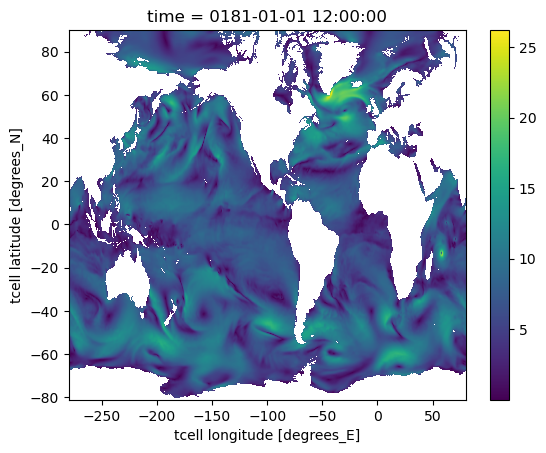

In [21]:
rho = 1000
drag_coeff = 1

windSpeed = np.sqrt(ds_merged.u_ref ** 2 + ds_merged.v_ref ** 2)
windSpeed.isel(time=0).plot()

In [22]:
airSeaVelDiff = np.sqrt( (ds_merged.u_ref - ds_merged.u_ocean) ** 2 + (ds_merged.v_ref - ds_merged.v_ocean) ** 2 )

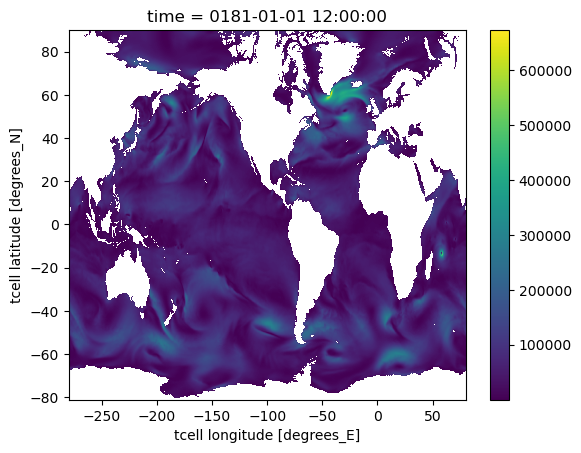

In [23]:
momFluxHighRes = rho * drag_coeff * windSpeed * airSeaVelDiff 
momFluxHighRes.isel(time=0).plot() 

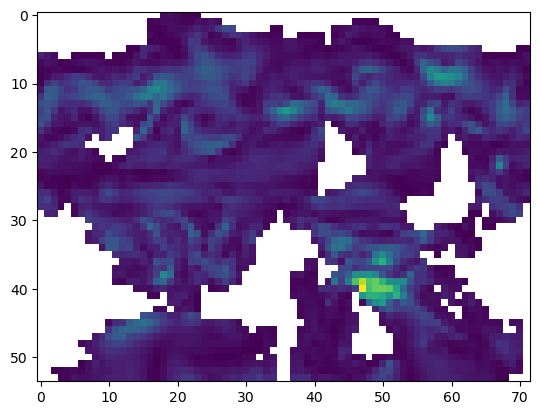

In [24]:
momFluxHighResDS = momFluxHighRes.to_dataset(name='data')
momFluxHRCoarsen = weighted_coarsen(momFluxHighResDS, {'xt_ocean':box_coarsen, 'yt_ocean':box_coarsen}, 'area_t')
momFluxHRCoarsenDA = momFluxHRCoarsen['data']
plt.imshow(momFluxHRCoarsenDA.isel(time=0))

In [25]:
Q_bar = momFluxHRCoarsen

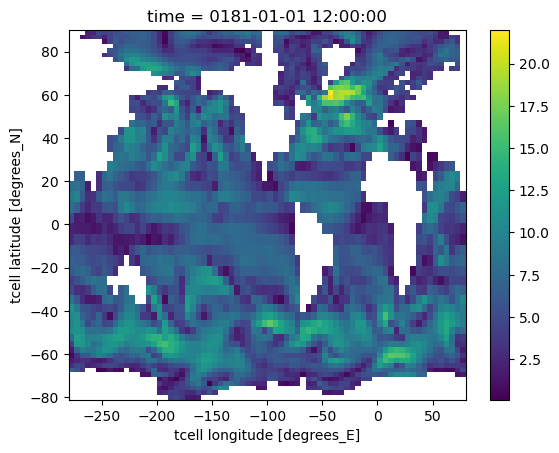

In [26]:
windSpeedCoarse = np.sqrt(ds_merged_coarse.u_ref ** 2 + ds_merged_coarse.v_ref ** 2)
windSpeedCoarse.isel(time=0).plot()

In [27]:
airSeaVelDiffCoarse = np.sqrt( (ds_merged_coarse.u_ref - ds_merged_coarse.u_ocean) ** 2 + (ds_merged_coarse.v_ref - ds_merged_coarse.v_ocean) ** 2 )

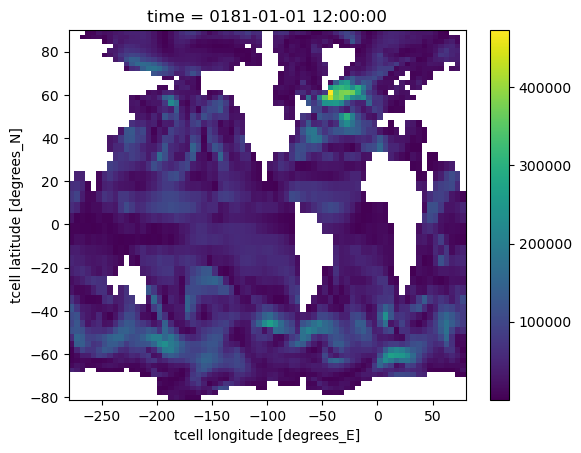

In [28]:
momFluxCoarse = rho * drag_coeff * windSpeedCoarse * airSeaVelDiffCoarse
momFluxCoarse.isel(time=0).plot()

In [29]:
Qc_bar = momFluxCoarse 

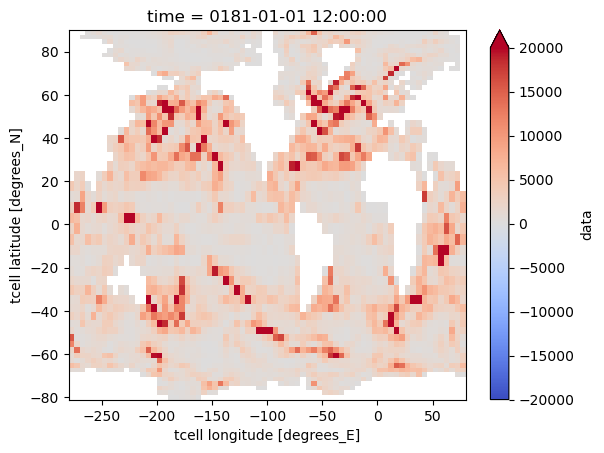

In [30]:
momFluxSGS = Q_bar - Qc_bar
momFluxSGS_DA = momFluxSGS['data'] 
momFluxSGS_DA.isel(time=0).plot(vmin=-20000, vmax=20000, cmap='coolwarm') #MOMENTUM FLUX!!!

# Aerobulk fluxes calculation

## Heat flux (Aerobulk)

In [31]:
from aerobulk import noskin

In [32]:
ql, qh, taux, tauy, evap =  noskin(
        ds_merged.surface_temp,
        ds_merged.t_ref,
        ds_merged.q_ref,
        ds_merged.u_relative,
        ds_merged.v_relative,
        slp=ds_merged.slp,
        algo='ecmwf',
        zt=2,
        zu=10,
)

Text(0.5, 1.0, 'Sensible Heat Flux, High-Res')

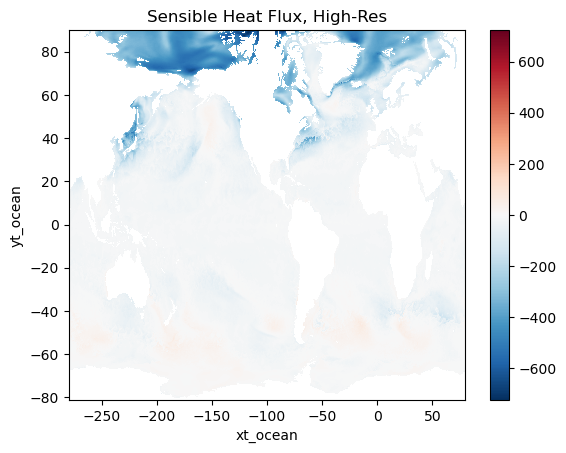

In [33]:
qh.isel(time=0).plot()
plt.title('Sensible Heat Flux, High-Res')

Text(0.5, 1.0, 'Latent Heat Flux, High-Res')

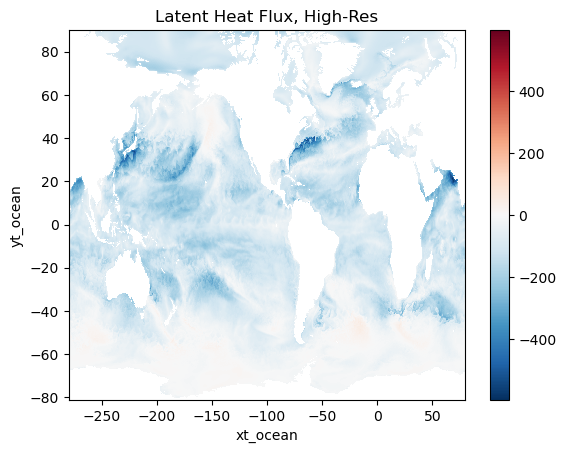

In [34]:
ql.isel(time=0).plot()
plt.title('Latent Heat Flux, High-Res')

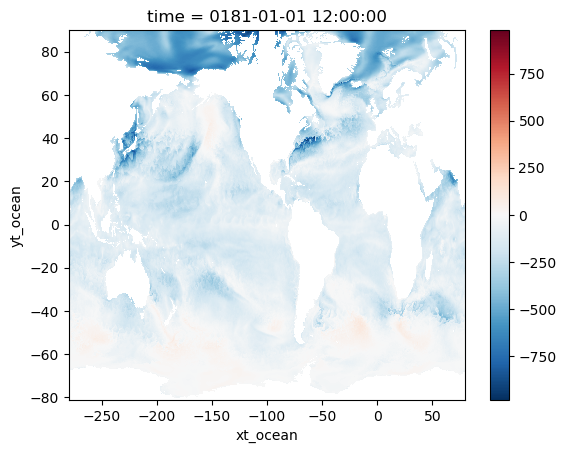

In [35]:
heatfluxHR = qh + ql
heatfluxHR.isel(time=0).plot()

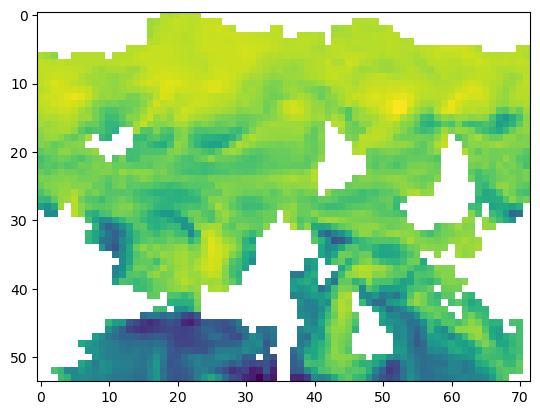

In [36]:
heatfluxHR_DS = heatfluxHR.to_dataset(name='data')
heatFluxHRcoarse = weighted_coarsen(heatfluxHR_DS, {'xt_ocean':box_coarsen, 'yt_ocean':box_coarsen}, 'area_t')
heatFluxHRcoarse_DA = heatFluxHRcoarse['data']
plt.imshow(heatFluxHRcoarse_DA.isel(time=0))

In [37]:
Qbar_aero = heatFluxHRcoarse_DA

In [38]:
ql_coarse, qh_coarse, taux_coarse, tauy_coarse, evap_coarse =  noskin(
        ds_merged_coarse.surface_temp,
        ds_merged_coarse.t_ref,
        ds_merged_coarse.q_ref,
        ds_merged_coarse.u_relative,
        ds_merged_coarse.v_relative,
        slp=ds_merged_coarse.slp,
        algo='ecmwf',
        zt=2,
        zu=10,
)

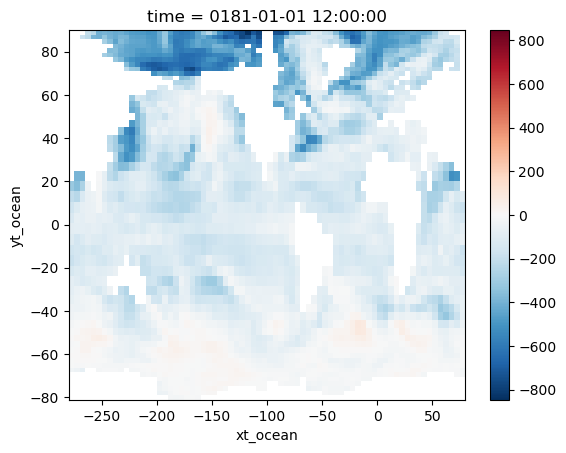

In [39]:
heatfluxLR = qh_coarse + ql_coarse
heatfluxLR.isel(time=0).plot()

In [40]:
Qcbar_aero = heatfluxLR

Text(0.5, 1.0, 'Q^* Heat Flux from AeroBulk')

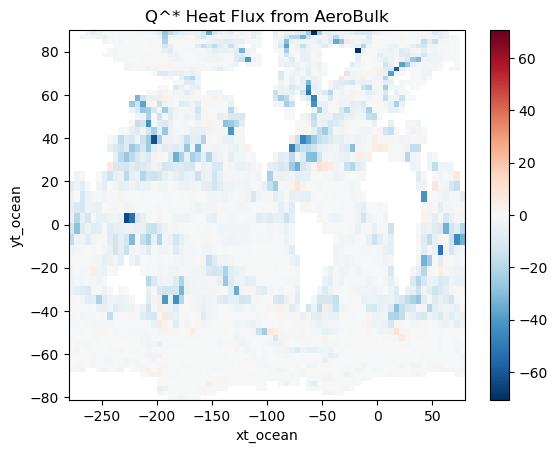

In [41]:
Qbar_star_aero = Qbar_aero - Qcbar_aero
Qbar_star_aero.isel(time=0).plot()
plt.title('Q^* Heat Flux from AeroBulk')

## Momentum Flux (Aerobulk)

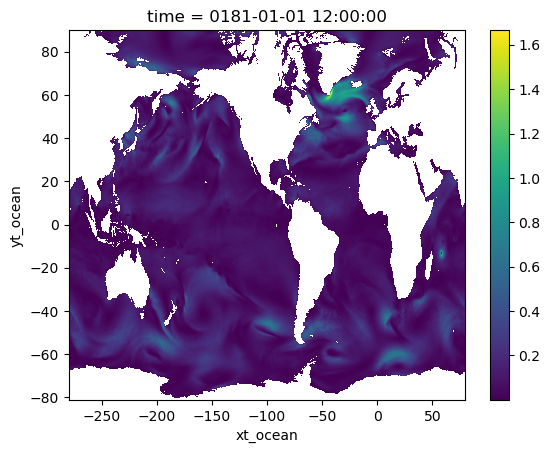

In [42]:
momfluxHR_aero = np.sqrt( (taux ** 2 + tauy ** 2) )
momfluxHR_aero.isel(time=0).plot()

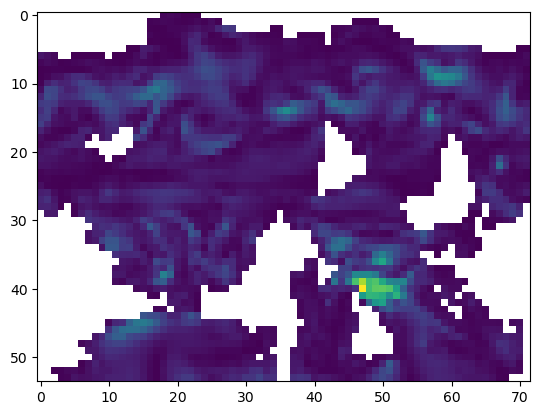

In [43]:
momfluxHR_aero_DS = momfluxHR_aero.to_dataset(name='data')
momfluxHR_aero_coarse = weighted_coarsen(momfluxHR_aero_DS, {'xt_ocean':box_coarsen, 'yt_ocean':box_coarsen}, 'area_t')
momfluxHR_aero_coarse_DA = momfluxHR_aero_coarse['data']
plt.imshow(momfluxHR_aero_coarse_DA.isel(time=0))

In [44]:
Mbar_aero = momfluxHR_aero_coarse_DA

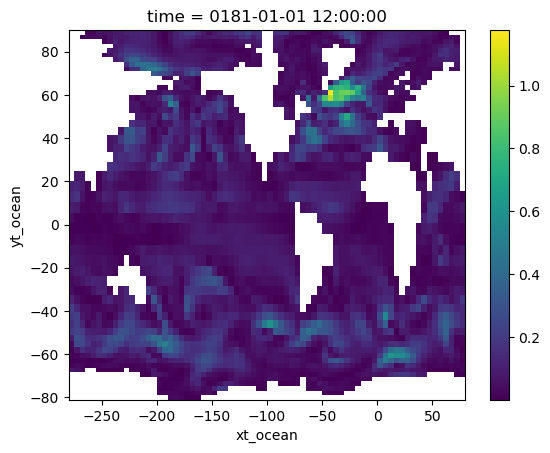

In [45]:
momfluxLR_aero = np.sqrt( (taux_coarse ** 2 + tauy_coarse ** 2) )
momfluxLR_aero.isel(time=0).plot()

In [46]:
Mcbar_aero = momfluxLR_aero

Text(0.5, 1.0, 'M* Momentum Flux')

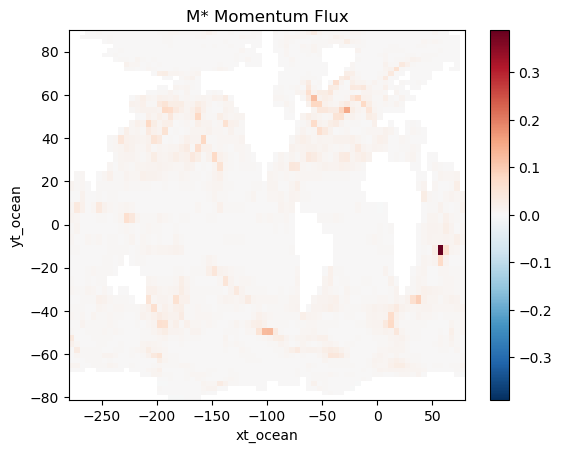

In [47]:
M_star_aero = Mbar_aero - Mcbar_aero
M_star_aero.isel(time=0).plot() 
plt.title('M* Momentum Flux')

## Freshwater flux

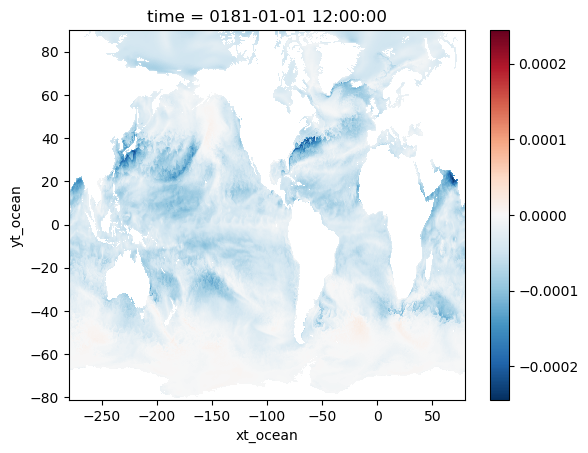

In [48]:
freshfluxHR_aero = evap
freshfluxHR_aero.isel(time=0).plot()

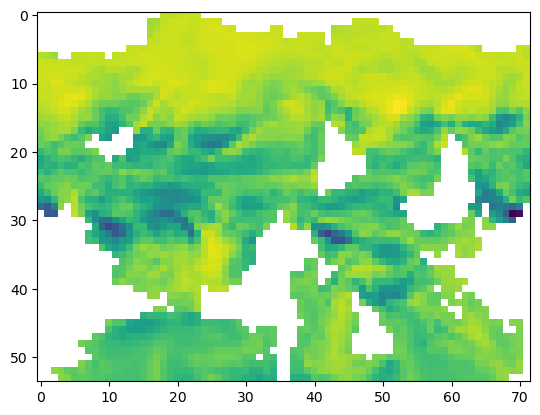

In [49]:
freshfluxHR_aero_DS = freshfluxHR_aero.to_dataset(name='data')
freshfluxHR_aero_coarse = weighted_coarsen(freshfluxHR_aero_DS, {'xt_ocean':box_coarsen, 'yt_ocean':box_coarsen}, 'area_t')
freshfluxHR_aero_coarse_DA = freshfluxHR_aero_coarse['data']
plt.imshow(freshfluxHR_aero_coarse_DA.isel(time=0))

In [50]:
Fbar = freshfluxHR_aero_coarse_DA

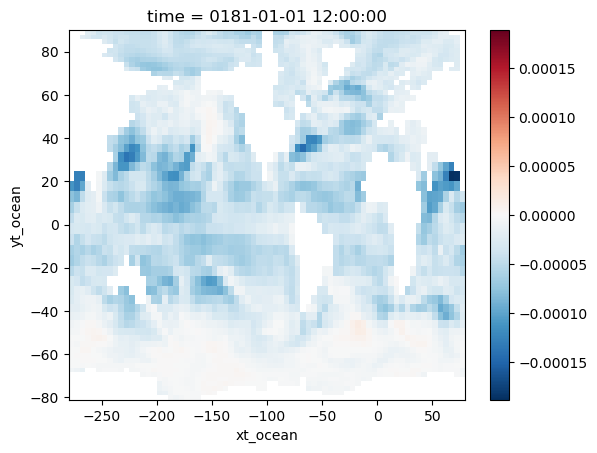

In [51]:
freshfluxLR_aero = evap_coarse
Fcbar = freshfluxLR_aero
Fcbar.isel(time=0).plot()

Text(0.5, 1.0, 'Freshwater Flux')

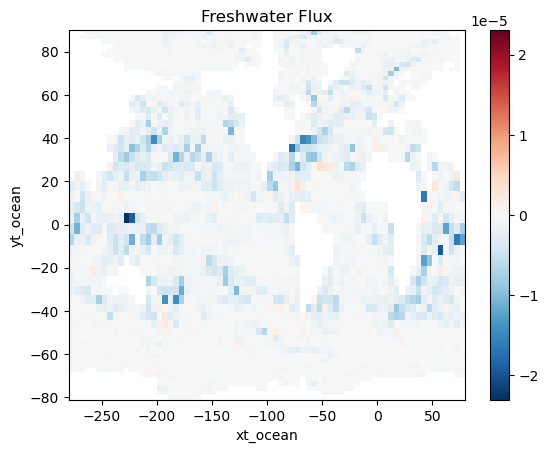

In [52]:
F_star_aero = Fbar - Fcbar
F_star_aero.isel(time=0).plot() 
plt.title('Freshwater Flux')